# Sistema de recomendacion usando Maquina Restringida de Boltzmann

Usando RBMs es creado un sistema de recomendacion basado en filtro colaborativo, un sistema que recomienda tratando de buscar usuarios con gustos parecidos basandose en la manera en que evaluan.

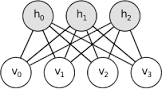

Las RBMs son redes neuronales superficiales que aprenden patrones y extren importantes caracteristicas en los datos al recontruir la entrada, contienen solamente dos capas y son ampliamente usadas para la reduccion de dimensionalidades, extraccion de caracteristicas y filtros colaborativos. Las llaman restringidas porque las neuronas de la misma capa no estan conectadas entre si.

# Descargar Datos

In [1]:
!wget -O moviedataset.zip http://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip -o moviedataset.zip -d /resources/data

--2017-06-12 09:50:00--  http://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.34.146
Connecting to files.grouplens.org (files.grouplens.org)|128.101.34.146|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5,6M) [application/zip]
Saving to: ‘moviedataset.zip’

moviedataset.zip    100%[===================>]   5,64M  1,20MB/s    in 5,1s    

2017-06-12 09:50:07 (1,11 MB/s) - ‘moviedataset.zip’ saved [5917549/5917549]

Archive:  moviedataset.zip
checkdir:  cannot create extraction directory: /resources/data
           No such file or directory


In [2]:
# importar librerias necesarias
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

-------------

# Cargar datos


In [7]:
# cargar base de datos de peliculas
movies_df = pd.read_csv('ml-1m/movies.dat', sep='::', header=None)
# movies_df es un dataframe que contiene id individual de cada pelicula - titulo - genero
movies_df.head()

/home/polo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


,0,1,2
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
# cargar base de datos de evaluaciones
ratings_df = pd.read_csv('ml-1m/ratings.dat', sep='::', header=None)
# ratings_df es un dataframe que contiene id de usuario - id de pelicula - evaluacion de la pelicula - fecha 
ratings_df.head()

/home/polo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


,0,1,2,3
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [8]:
# renombrar las columnas en los dataframes para mejor manejo de datos
movies_df.columns = ['MovieID', 'Title', 'Genres']
ratings_df.columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']

In [9]:
# nueva visualizacion
movies_df.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [10]:
# nueva visualizacion
ratings_df.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


-----------

# Modelo Maquinas Restringidas de Boltzmann

<img src="https://ibm.box.com/shared/static/o049tx0dsllpbj3b546vuba25qqlzelq.png" alt="RBM Model" style="width: 300px;"/>

Las RBMs tiene dos capas de neuronas, una en la entrada llamada capa visible y la capa oculta. La capa oculta aprende caracteristicas de la informacion que llega de la capa de entrada. Para el modelo se tendra x cantidad de neuronas en la entrada que corresponden a la cantidad de peliculas en la base de datos. Cada una contendra un valor que varia de 0 a 1 indicando que el usuario no a visto la pelicula si el valor es 0 y si mientras mas le guste la pelicula el valor se acerca mas a 1 de la neurona que esta representando. 


## Exploracion de datos

In [11]:
# cantidad de peliculas
len(movies_df)

3883

In [12]:
# cola del dataframe
movies_df.tail()

,MovieID,Title,Genres
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama
3882,3952,"Contender, The (2000)",Drama|Thriller


In [13]:
# tenemos 3883 peliculas y nuestras id varian de 1 a 3952, debido a esto no podremos indexar peliculas por su
# id ya que tendriamos errores de indexacion en memoria
# para lograr eso se crea una columna que enseña una lista con la pelicula particular 
movies_df['List Index'] = movies_df.index
movies_df.head()

,MovieID,Title,Genres,List Index
0,1,Toy Story (1995),Animation|Children's|Comedy,0
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1
2,3,Grumpier Old Men (1995),Comedy|Romance,2
3,4,Waiting to Exhale (1995),Comedy|Drama,3
4,5,Father of the Bride Part II (1995),Comedy,4


In [14]:
# fusionando movies_df con ratings_df
merged_df = movies_df.merge(ratings_df, on='MovieID')
# descartando columnas innecesarias
merged_df = merged_df.drop('Timestamp', axis=1).drop('Title', axis=1).drop('Genres', axis=1)
# visualizacion
merged_df.head()

,MovieID,List Index,UserID,Rating
0,1,0,1,5
1,1,0,6,4
2,1,0,8,4
3,1,0,9,5
4,1,0,10,5


In [15]:
# agrupar usuarios por id
userGroup = merged_df.groupby('UserID')
userGroup.first().head()

,MovieID,List Index,Rating
UserID,,,
1,1,0,5
2,21,20,1
3,104,102,4
4,260,257,5
5,6,5,2


In [16]:
# cantidad de usuarios en el entrenamiento
amountOfUsedUsers = 1000
# crear lista de entrenamiento
trX = []
# por cada usuario en el grupo
for userID, curUser in userGroup:
    # crear un temp que almacena cada evaluacion de la pelicula
    temp = [0]*len(movies_df)
    # por cada pelicula en curUser
    for num, movie in curUser.iterrows():
        # dividir la evaluacion en 5 y almacenarla
        temp[movie['List Index']] = movie['Rating']/5.0
    # agregar la lista de evaluaciones en una lista de entrenamiento
    trX.append(temp)
    if amountOfUsedUsers == 0:
        break
    amountOfUsedUsers -= 1

------------

# Sintonizando parametros del modelo

In [17]:
hiddenUnits = 20
visibleUnits = len(movies_df)
# numero unico de peliculas
vb = tf.placeholder("float", [visibleUnits])
# numero de caracteristicas de las que se aprendera
hb = tf.placeholder("float", [hiddenUnits]) 
W = tf.placeholder("float", [visibleUnits, hiddenUnits])

In [18]:
# entrada
v0 = tf.placeholder("float", [None, visibleUnits])
_h0= tf.nn.sigmoid(tf.matmul(v0, W) + hb)
h0 = tf.nn.relu(tf.sign(_h0 - tf.random_uniform(tf.shape(_h0))))
# reconstruccion
_v1 = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(W)) + vb) 
v1 = tf.nn.relu(tf.sign(_v1 - tf.random_uniform(tf.shape(_v1))))
h1 = tf.nn.sigmoid(tf.matmul(v1, W) + hb)

In [19]:
# taza de aprendizaje
alpha = 1.0
# calculo de gradientes
w_pos_grad = tf.matmul(tf.transpose(v0), h0)
w_neg_grad = tf.matmul(tf.transpose(v1), h1)
# calcular la divergencia contrastiva para maximizarC
CD = (w_pos_grad - w_neg_grad) / tf.to_float(tf.shape(v0)[0])
# metodos para actualizar pesos y sesgos
update_w = W + alpha * CD
update_vb = vb + alpha * tf.reduce_mean(v0 - v1, 0)
update_hb = hb + alpha * tf.reduce_mean(h0 - h1, 0)

In [20]:
# funcion de error
err = v0 - v1
err_sum = tf.reduce_mean(err * err)

In [21]:
cur_w = np.zeros([visibleUnits, hiddenUnits], np.float32)
cur_vb = np.zeros([visibleUnits], np.float32)
cur_hb = np.zeros([hiddenUnits], np.float32)
prv_w = np.zeros([visibleUnits, hiddenUnits], np.float32)
prv_vb = np.zeros([visibleUnits], np.float32)
prv_hb = np.zeros([hiddenUnits], np.float32)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

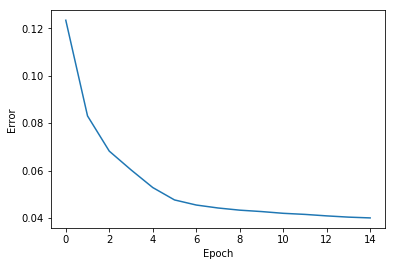

In [22]:
epochs = 15
batchsize = 100
errors = []
for i in range(epochs):
    for start, end in zip( range(0, len(trX), batchsize), range(batchsize, len(trX), batchsize)):
        batch = trX[start:end]
        cur_w = sess.run(update_w, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_vb = sess.run(update_vb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_nb = sess.run(update_hb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        prv_w = cur_w
        prv_vb = cur_vb
        prv_hb = cur_nb
    errors.append(sess.run(err_sum, feed_dict={v0: trX, W: cur_w, vb: cur_vb, hb: cur_nb}))
plt.plot(errors)
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()

--------------

# Recomendacion

In [23]:
# seleccionar usuario
inputUser = [trX[75]]

In [24]:
# ingresar el usuario y reconstruir la entrada
hh0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)
feed = sess.run(hh0, feed_dict={ v0: inputUser, W: prv_w, hb: prv_hb})
rec = sess.run(vv1, feed_dict={ hh0: feed, W: prv_w, vb: prv_vb})

In [26]:
# imprimir las 20 peliculas recomendadas 
movies_df["Recommendation Score"] = rec[0]
movies_df.sort_values(["Recommendation Score"], ascending=False).head(20)

,MovieID,Title,Genres,List Index,Recommendation Score
2327,2396,Shakespeare in Love (1998),Comedy|Romance,2327,0.782526
2789,2858,American Beauty (1999),Comedy|Drama,2789,0.756972
2928,2997,Being John Malkovich (1999),Comedy,2928,0.682616
523,527,Schindler's List (1993),Drama|War,523,0.659886
604,608,Fargo (1996),Crime|Drama|Thriller,604,0.655749
2693,2762,"Sixth Sense, The (1999)",Thriller,2693,0.635672
315,318,"Shawshank Redemption, The (1994)",Drama,315,0.607131
1575,1617,L.A. Confidential (1997),Crime|Film-Noir|Mystery|Thriller,1575,0.601868
589,593,"Silence of the Lambs, The (1991)",Drama|Thriller,589,0.601555
1959,2028,Saving Private Ryan (1998),Action|Drama|War,1959,0.555270


In [36]:
def recomendar(id_us):
    # seleccionar usuario
    inputUser = [trX[id_us]]
    # ingresar el usuario y reconstruir la entrada
    hh0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
    vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)
    feed = sess.run(hh0, feed_dict={ v0: inputUser, W: prv_w, hb: prv_hb})
    rec = sess.run(vv1, feed_dict={ hh0: feed, W: prv_w, vb: prv_vb})
    # imprimir las 20 peliculas recomendadas 
    movies_df["Recommendation Score"] = rec[0]
    return movies_df.sort_values(["Recommendation Score"], ascending=False).head(20)
    


In [37]:
print(recomendar(75))

      MovieID                             Title  \
2327     2396        Shakespeare in Love (1998)   
2789     2858            American Beauty (1999)   
2928     2997       Being John Malkovich (1999)   
523       527           Schindler's List (1993)   
604       608                      Fargo (1996)   
2693     2762           Sixth Sense, The (1999)   
315       318  Shawshank Redemption, The (1994)   
1575     1617          L.A. Confidential (1997)   
589       593  Silence of the Lambs, The (1991)   
1959     2028        Saving Private Ryan (1998)   
2530     2599                   Election (1999)   
0           1                  Toy Story (1995)   
1245     1265              Groundhog Day (1993)   
3091     3160                   Magnolia (1999)   
3509     3578                  Gladiator (2000)   
293       296               Pulp Fiction (1994)   
1726     1784         As Good As It Gets (1997)   
1656     1704          Good Will Hunting (1997)   
3339     3408            Erin B

In [39]:
# seleccionar usuario
inputUser = [trX[0]]
# ingresar el usuario y reconstruir la entrada
hh0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)
feed = sess.run(hh0, feed_dict={ v0: inputUser, W: prv_w, hb: prv_hb})
rec = sess.run(vv1, feed_dict={ hh0: feed, W: prv_w, vb: prv_vb})
# imprimir las 20 peliculas recomendadas 
movies_df["Recommendation Score"] = rec[0]
movies_df.sort_values(["Recommendation Score"], ascending=False).head(20)



,MovieID,Title,Genres,List Index,Recommendation Score
315,318,"Shawshank Redemption, The (1994)",Drama,315,0.565643
523,527,Schindler's List (1993),Drama|War,523,0.558544
589,593,"Silence of the Lambs, The (1991)",Drama|Thriller,589,0.552870
604,608,Fargo (1996),Crime|Drama|Thriller,604,0.537006
2327,2396,Shakespeare in Love (1998),Comedy|Romance,2327,0.536390
1575,1617,L.A. Confidential (1997),Crime|Film-Noir|Mystery|Thriller,1575,0.530238
257,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,257,0.513997
1959,2028,Saving Private Ryan (1998),Action|Drama|War,1959,0.505203
0,1,Toy Story (1995),Animation|Children's|Comedy,0,0.430407
1245,1265,Groundhog Day (1993),Comedy|Romance,1245,0.384674
